In [16]:
# pip install pmdarima

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [11]:
warnings.filterwarnings("ignore")

<h1>Sensor 1 Data as of 12 March 2024, 12:40PM</h1>

In [10]:
df1 = pd.read_csv('../data/sensor1.csv')

<h3>Data Cleaning</h3>

We are focusing on <b>CO2</b>, <b>Humidity</b>, and <b>Temperature</b> variables.

In [12]:
df1.drop(["PM10", "PM2.5", "TVOC"], axis=1, inplace=True)

In [13]:
df1 = df1.dropna()

In [14]:
df1.shape

(186, 4)

In [15]:
units_dict = {}

for col in df1.columns[1:]:
    values = []
    units = set()
    for val in df1[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df1.rename(columns={col: new_col_name}, inplace=True)
    df1[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [16]:
df1['Time'] = pd.to_datetime(df1['Time'])
df1['Time'] = df1['Time'].dt.date

In [17]:
df1.index = df1['Time']
df1.drop(columns=['Time'], inplace=True)

In [18]:
df1.head()

,CO2 (ppm),Humidity (%H),Temperature (°C)
Time,,,
2024-03-12,510,77.9,23.3
2024-03-11,701,77.6,23.8
2024-03-10,513,79.0,24.7
2024-03-09,532,80.0,23.6
2024-03-08,734,79.6,23.6


<h3>Plot Charts</h3>

Let's look at <em>Temperature (°C)</em> first.

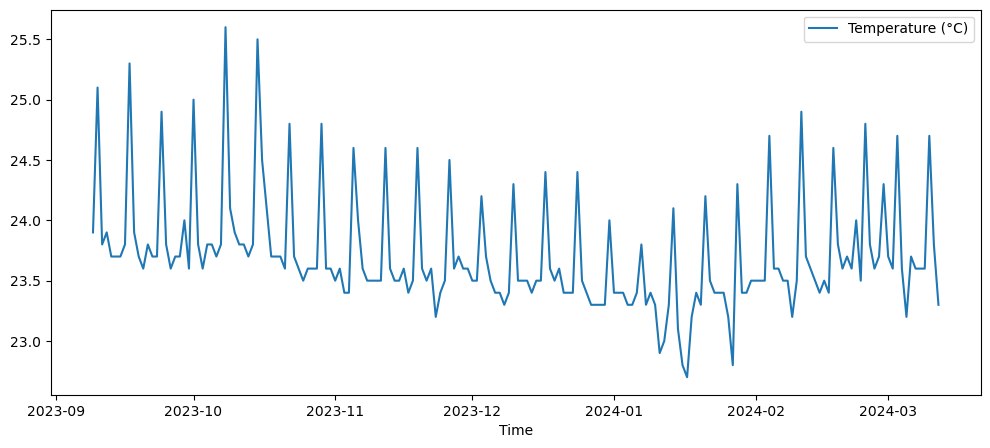

In [19]:
df1["Temperature (°C)"].plot(figsize=(12,5))

plt.legend()

Below is to check for stationarity

<b>H0:</b> It is non-stationary <br>
<b>H1:</b> It is stationary

If `p-value <= 0.05`, it has <b>strong</b> evidence against the null hypothesis (H0). We can reject the null hypothesis and conclude that data has no unit root and is stationary.

Else, it has <b>weak</b> evidence against the null hypothesis. We can accept the null hypothesis and conlude that the time series has a unit root and is non-stationary. 

In [20]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF: ", dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Number of Lags:", dftest[2])
    print("4. Number of Observations Used for ADF Regression and Critical Values Calculation: ", dftest[3])
    print("5. Critical Values: ")
    for key, value in dftest[4].items():
        print("\t", key, ": ", value)

In [21]:
ad_test(df1["Temperature (°C)"])

1. ADF:  -1.346436492658241
2. P-Value:  0.6076690800942378
3. Number of Lags: 15
4. Number of Observations Used for ADF Regression and Critical Values Calculation:  170
5. Critical Values: 
	 1% :  -3.469413468959902
	 5% :  -2.8786964197028295
	 10% :  -2.5759166089965397


Time series for <em>Temperature (°C)</em> is <b>non-stationary</b> thus differencing is used.

In [22]:
df1["Temperature Seasonal Difference"] = df1["Temperature (°C)"] - df1["Temperature (°C)"].shift(1)

In [23]:
ad_test(df1["Temperature Seasonal Difference"].dropna())

1. ADF:  -3.8176464346009387
2. P-Value:  0.0027318421361664747
3. Number of Lags: 14
4. Number of Observations Used for ADF Regression and Critical Values Calculation:  170
5. Critical Values: 
	 1% :  -3.469413468959902
	 5% :  -2.8786964197028295
	 10% :  -2.5759166089965397


Now, we can reject the null hypothesis and conclude that time series for <em>Temperature (°C)</em> is <b>stationary</b>.

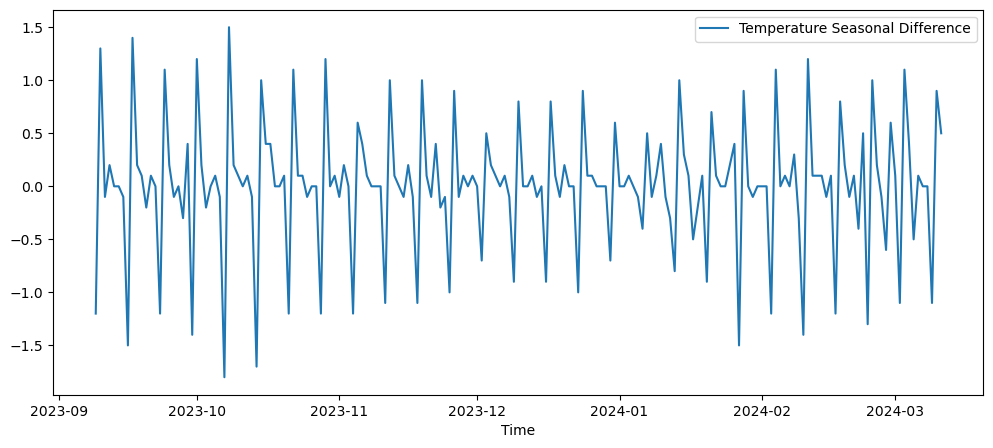

In [24]:
df1["Temperature Seasonal Difference"].plot(figsize=(12,5))

plt.legend()

Next, to predict C02, we need to find out how many previous data is required to be considered. <br>

`auto_arima` function helps to automatically determine the <b>order (p, d, q)</b> of the ARIMA.

<b>p</b> refers to the AR model lags <br>
<b>d</b> refers to the differencing <br>
<b>q</b> refers to the Moving Average lags

In [25]:
stepwise_fit_temp = auto_arima(df1["Temperature Seasonal Difference"].dropna(), trace=True, suppress_warnings=True)
stepwise_fit_temp.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=230.527, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=346.814, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=311.741, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=238.917, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.819, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=230.730, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=239.464, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=232.511, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=206.464, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=230.090, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=199.650, Time=0.07 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=198.411, Time=0.08 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=217.007, Time=0.09 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=159.140, Time=0.15 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=148.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  185
Model:               SARIMAX(5, 0, 2)   Log Likelihood                 -64.918
Date:                Tue, 12 Mar 2024   AIC                            145.836
Time:                        23:26:49   BIC                            171.599
Sample:                             0   HQIC                           156.277
                                - 185                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0049      0.066     -0.074      0.941      -0.133       0.124
ar.L2         -0.5592      0.071     -7.895      0.000      -0.698      -0.420
ar.L3         -0.4278      0.085     -5.043      0.000      -0.594      -0.262
ar.L4         -0.3960      0.079     -5.018      0.000      -0.551      -0.241
ar.L5         -0.5744      0.084     -6.856      0.000      -0.739      -0.410
ma.L1         -1.1441      0.047    -24.157      0.000      -1.237      -1.051
ma.L2          0.8723      0.046     19.047      0.000       0.783       0.962
sigma2         0.1142      0.012      9.760      0.000       0.091       0.137
===================================================================================
Ljung-Box (L1) (Q):                   3.76   Jarque-Bera (JB):                 6.39
Prob(Q):                              0.05   Prob(JB):                         0.04
Heteroskedasticity (H):               1.00   Skew:                             0.33
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model is of <b>(5,0,2)</b> order and the data does not exhibit seasonality. 

Autocorrelation and partial corrlation functions plots help to provide insights into the underlying structure of the time series for <em>Temperature (°C)</em>.

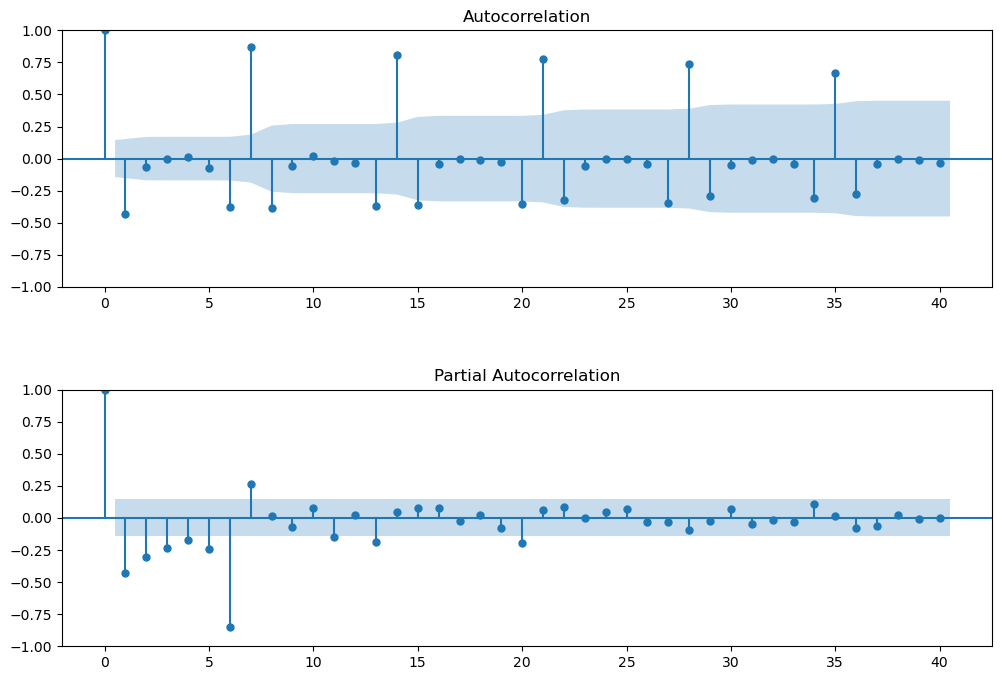

In [26]:
fig_temp = plt.figure(figsize=(12,8))
ax1_temp = fig_temp.add_subplot(211)
fig_temp = sm.graphics.tsa.plot_acf(df1["Temperature Seasonal Difference"].iloc[2:], lags=40, ax=ax1_temp)
ax2_temp = fig_temp.add_subplot(212)
fig_temp = sm.graphics.tsa.plot_pacf(df1["Temperature Seasonal Difference"].iloc[2:], lags=40, ax=ax2_temp)

plt.subplots_adjust(hspace=0.4)

In [27]:
print(df1.shape)
train1 = df1.iloc[:-30]
test1 = df1.iloc[-30:]
print(train1.shape, test1.shape)

(186, 4)
(156, 4) (30, 4)


Since the data does not exhibit seasonality, ARIMA is used.

In [28]:
model_temp = ARIMA(train1["Temperature (°C)"], order=(5, 0, 2))
model_temp = model_temp.fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Temperature (°C)   No. Observations:                  156
Model:                 ARIMA(5, 0, 2)   Log Likelihood                 -57.533
Date:                Tue, 12 Mar 2024   AIC                            133.066
Time:                        23:26:57   BIC                            160.515
Sample:                             0   HQIC                           144.215
                                - 156                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.6538      0.039    603.458      0.000      23.577      23.731
ar.L1         -0.0369      0.089     -0.414      0.679      -0.212       0.138
ar.L2         -0.5827      0.091     -6.379      0.000      -0.762      -0.404
ar.L3          0.1300      0.107      1.214      0.225      -0.080       0.340
ar.L4          0.0749      0.107      0.701      0.483      -0.134       0.284
ar.L5         -0.3622      0.084     -4.330      0.000      -0.526      -0.198
ma.L1          0.2755      0.029      9.624      0.000       0.219       0.332
ma.L2          0.9787      0.054     18.056      0.000       0.872       1.085
sigma2         0.1168      0.015      7.584      0.000       0.087       0.147
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.40
Prob(Q):                              0.88   Prob(JB):                         0.02
Heteroskedasticity (H):               1.18   Skew:                             0.49
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start1 = len(train1)
end1 = len(train1) + len(test1) - 1

In [30]:
pred_temp = model_temp.predict(start=start1, end=end1, typ="levels")
pred_temp.index = df1.index[start1:end1+1]
print(pred_temp)

Time
2023-10-08    24.182686
2023-10-07    23.544819
2023-10-06    23.373141
2023-10-05    23.740634
2023-10-04    23.677933
2023-10-03    23.366092
2023-10-02    23.680111
2023-10-01    23.931776
2023-09-30    23.561171
2023-09-29    23.468393
2023-09-28    23.856942
2023-09-27    23.753581
2023-09-26    23.400029
2023-09-25    23.651108
2023-09-24    23.897110
2023-09-23    23.547293
2023-09-22    23.460472
2023-09-21    23.846349
2023-09-20    23.764694
2023-09-19    23.416279
2023-09-18    23.647091
2023-09-17    23.891311
2023-09-16    23.556629
2023-09-15    23.460175
2023-09-14    23.833979
2023-09-13    23.767557
2023-09-12    23.426143
2023-09-11    23.640046
2023-09-10    23.885377
2023-09-09    23.566930
Name: predicted_mean, dtype: float64


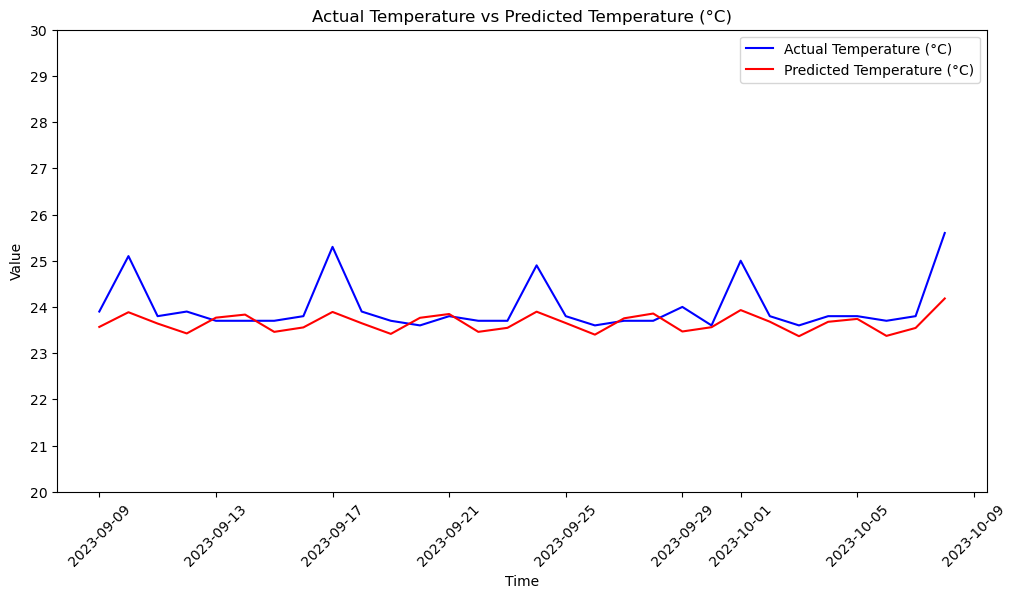

In [46]:
y_min_temp = min(test1["Temperature (°C)"].min(), pred_temp.min())
y_max_temp = max(test1["Temperature (°C)"].max(), pred_temp.max())

y_min_rounded_temp = np.floor(y_min_temp / 10) * 10
y_max_rounded_temp = np.ceil(y_max_temp / 10) * 10

plt.figure(figsize=(12, 6))
plt.plot(test1.index, test1["Temperature (°C)"], label='Actual Temperature (°C)', color='blue')
plt.plot(test1.index, pred_temp, label='Predicted Temperature (°C)', color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual Temperature vs Predicted Temperature (°C)')
plt.legend()
plt.yticks(np.arange(y_min_rounded_temp, y_max_rounded_temp+1, 1))
plt.xticks(rotation=45)

plt.show()

In [33]:
rmse = sqrt(mean_squared_error(test1['Temperature (°C)'], pred_temp))
print("RMSE:", round(rmse,2))

RMSE: 0.55


With a RMSE value of <b>0.55</b>, we conclude that this model is decent. We will then proceed to re-train the model on the entire dataset and make prediction on future value.

In [39]:
model_temp2 = ARIMA(df1["Temperature (°C)"], order=(5, 0, 2))
model_temp2 = model_temp2.fit()
df1.head()

,CO2 (ppm),Humidity (%H),Temperature (°C),Temperature Seasonal Difference
Time,,,,
2024-03-12,510,77.9,23.3,NaN
2024-03-11,701,77.6,23.8,0.5
2024-03-10,513,79.0,24.7,0.9
2024-03-09,532,80.0,23.6,-1.1
2024-03-08,734,79.6,23.6,0.0


We will make a prediction on the next <b>30</b> days.

In [51]:
index_future_dates = pd.date_range(start=df1.index[0], end=df1.index[0] + pd.Timedelta(days=30))
pred_temp2 = model_temp2.predict(start=len(df1), end=len(df1) + 30, typ="levels").rename("ARIMA Predictions")
pred_temp2.index = index_future_dates
pred_temp2

2024-03-12    23.835272
2024-03-13    23.794705
2024-03-14    23.773322
2024-03-15    24.214243
2024-03-16    23.865697
2024-03-17    24.067861
2024-03-18    23.840272
2024-03-19    23.937846
2024-03-20    23.954776
2024-03-21    23.910726
2024-03-22    23.981734
2024-03-23    23.885162
2024-03-24    23.950468
2024-03-25    23.902586
2024-03-26    23.926013
2024-03-27    23.921840
2024-03-28    23.905032
2024-03-29    23.921704
2024-03-30    23.897554
2024-03-31    23.913575
2024-04-01    23.899045
2024-04-02    23.902529
2024-04-03    23.899329
2024-04-04    23.893630
2024-04-05    23.896468
2024-04-06    23.888752
2024-04-07    23.891144
2024-04-08    23.885738
2024-04-09    23.885091
2024-04-10    23.882770
2024-04-11    23.879871
Freq: D, Name: ARIMA Predictions, dtype: float64

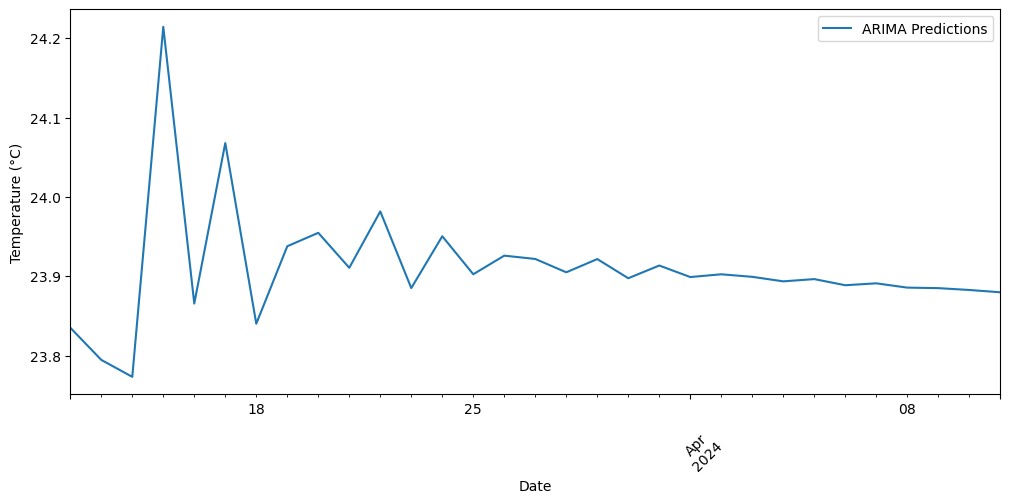

In [52]:
plt.figure(figsize=(12, 5))
pred_temp2.plot(legend=True)

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)

plt.show()